## Технологии машинного обучения

## Практическая 3. Классификация

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. 

**Обратите внимание**, что в каждом разделе практического задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи.

In [ ]:
!pip install mlxtend==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1.5 балла)__

Обучите метод опорных векторов. Линейный вариант без ядрового перехода соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [ ]:
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_auc_score, average_precision_score,\
                            precision_recall_curve, PrecisionRecallDisplay,\
                            RocCurveDisplay

In [ ]:
svm = SVC(kernel='linear')
C = np.linspace(0.001, 5, 15)
params = {'C': C}
SVM_grid = GridSearchCV(svm, params, scoring='average_precision')
SVM_grid.fit(X_train, y_train)
res = SVM_grid.cv_results_['mean_test_score']
SVM_grid.best_params_

{'C': 0.001}

In [ ]:
svm = SVC(C=SVM_grid.best_params_['C'], kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.decision_function(X_test)

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

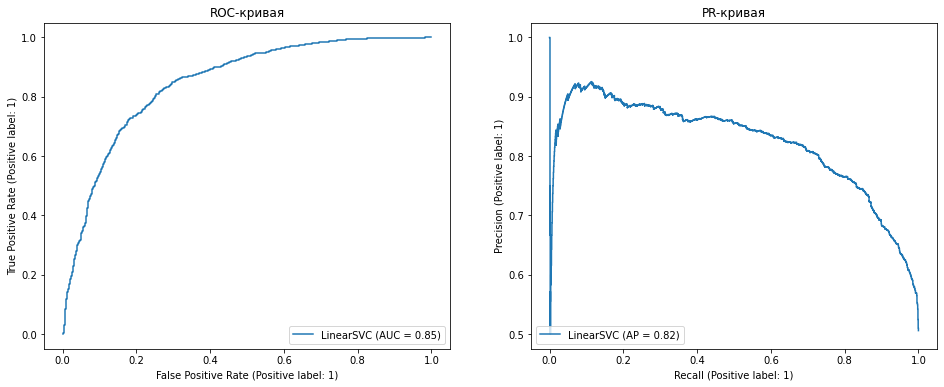

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

RocCurveDisplay.from_predictions(
    y_test, y_pred, name="LinearSVC", ax=ax[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred, name="LinearSVC", ax=ax[1]
)
ax[0].set_title("ROC-кривая")
ax[1].set_title("PR-кривая")

plt.show()

In [ ]:
print(f'AUC-ROC: {round(roc_auc_score(y_test, y_pred), 5)}')

AUC-ROC: 0.84726


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.82136


In [ ]:
y_pred_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])

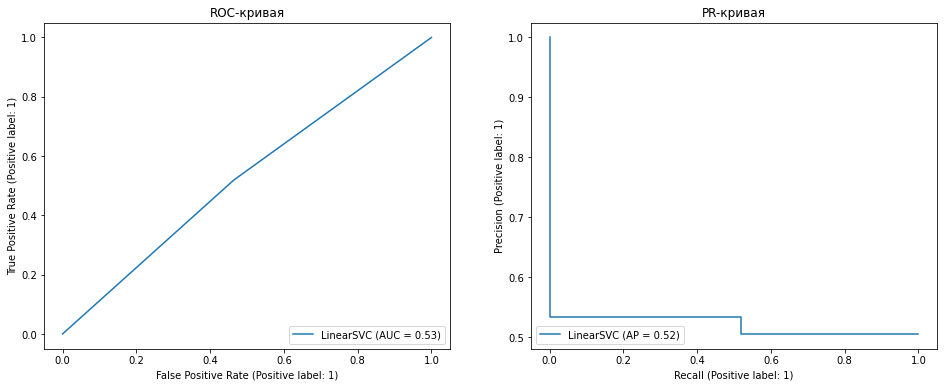

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

RocCurveDisplay.from_predictions(
    y_test, y_pred_random, name="LinearSVC", ax=ax[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_random, name="LinearSVC", ax=ax[1]
)
ax[0].set_title("ROC-кривая")
ax[1].set_title("PR-кривая")

plt.show()

In [ ]:
print(f'AUC-ROC: {round(roc_auc_score(y_test, y_pred_random), 5)}')

AUC-ROC: 0.52743


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_random)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.64784


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества.

In [ ]:
logreg = LogisticRegression()
C = np.linspace(0.001, 5, 15)
params = {'C': C}
logreg_grid = GridSearchCV(logreg, params, scoring='average_precision')
logreg_grid.fit(X_train, y_train)
res = logreg_grid.cv_results_['mean_test_score']
logreg_grid.best_params_

{'C': 0.001}

In [ ]:
logreg = LogisticRegression(C=logreg_grid.best_params_['C'])
logreg.fit(X_train, y_train)
y_pred = logreg.decision_function(X_test)

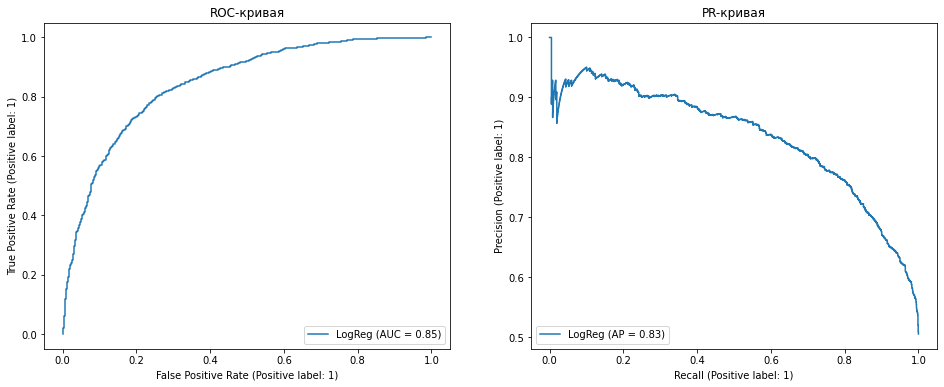

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

RocCurveDisplay.from_predictions(
    y_test, y_pred, name="LogReg", ax=ax[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test, y_pred, name="LogReg", ax=ax[1]
)
ax[0].set_title("ROC-кривая")
ax[1].set_title("PR-кривая")

plt.show()

In [ ]:
print(f'AUC-ROC: {round(roc_auc_score(y_test, y_pred), 5)}')

AUC-ROC: 0.84534


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.8336


В целом, обе модели превосходят baseline-модель и дают схожие значения метрик, хотя значение AUC-ROC немного выше у SVM, а AUC-PR - у LogReg.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [ ]:
X_ov, y_ov = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(
    X_ov, y_ov, test_size=0.3, random_state=42)

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_ov, y_ov);

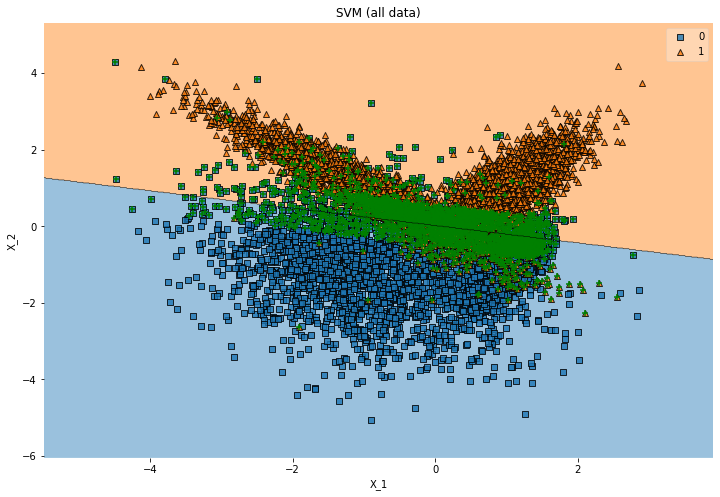

In [ ]:
plt.figure(figsize=(12,8))
plot_decision_regions(X_ov, y_ov, svm)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], marker='+', color='green')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.title('SVM (all data)')
plt.show()

In [ ]:
svm.fit(X_train_ov, y_train_ov);

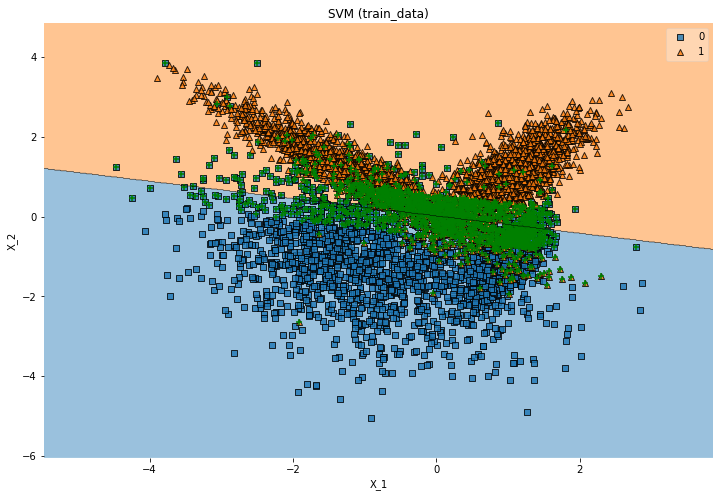

In [ ]:
plt.figure(figsize=(12,8))
plot_decision_regions(X_train_ov, y_train_ov, svm)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], marker='+', color='green')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.title('SVM (train_data)')
plt.show()

Стоит отметить, что в качестве опорных векторов выступают также объекты, классифицированные по итогу неверно.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # здесь был минус
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # здесь был min
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

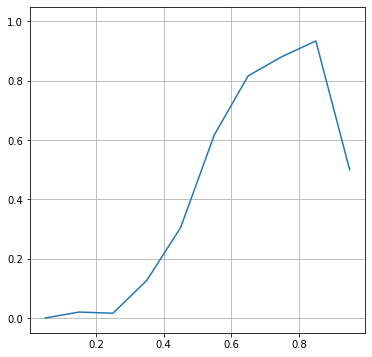

In [ ]:
svm = SVC(C=SVM_grid.best_params_['C'], kernel='linear')
svm.fit(X_train, y_train)
svc_pred = svm.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, svc_pred)

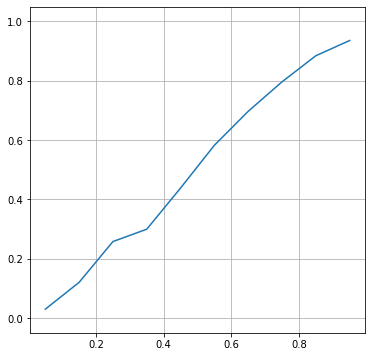

In [ ]:
logreg = LogisticRegression(C=logreg_grid.best_params_['C'])
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, logreg_pred)

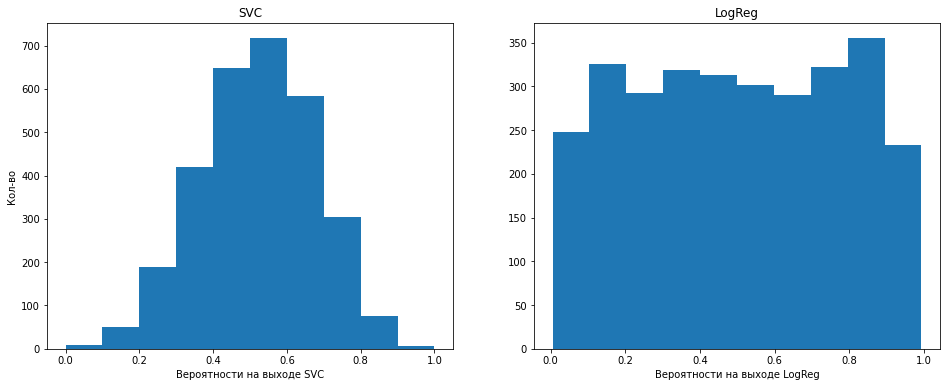

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(svc_pred)
ax[1].hist(logreg_pred)

ax[0].set_xlabel('Вероятности на выходе SVC')
ax[1].set_xlabel('Вероятности на выходе LogReg')

ax[0].set_ylabel('Кол-во')

ax[0].set_title('SVC')
ax[1].set_title('LogReg')

plt.show()

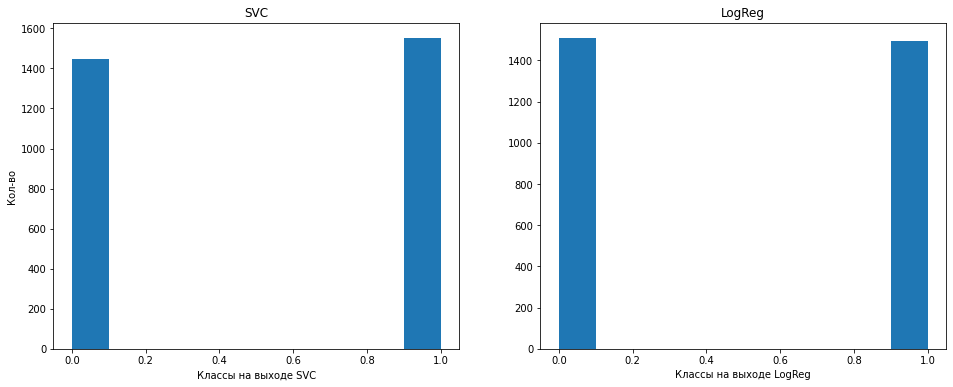

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(svm.predict(X_test))
ax[1].hist(logreg.predict(X_test))

ax[0].set_xlabel('Классы на выходе SVC')
ax[1].set_xlabel('Классы на выходе LogReg')

ax[0].set_ylabel('Кол-во')

ax[0].set_title('SVC')
ax[1].set_title('LogReg')

plt.show()

Распределения вероятностей у SVC и LogReg похожи на нормальное и равномерное соответственно. У SVC небольшой перекос в сторону отрицательного класса, а у LogReg более равномерно. Возможно, разницу можно объяснить тем, что объекты, которые SVC классифицирует неуверенно, в большинстве принадлежат положительному классу.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

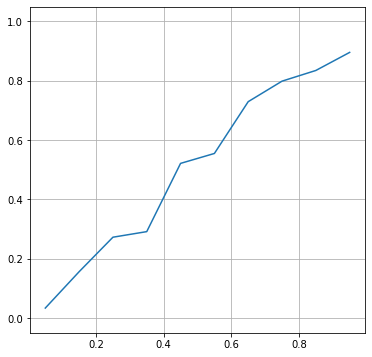

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

svm = SVC(C=SVM_grid.best_params_['C'], kernel='linear')
calibrated_svm = CalibratedClassifierCV(svm, cv=3)
calibrated_svm.fit(X_train, y_train)
svm_cal = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, svm_cal)

Да, улучшилась.

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-03-23 14:06:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 434.15K  1.35MB/s    in 0.3s    

2023-03-23 14:06:29 (1.35 MB/s) - ‘bank-additional.zip.1’ saved [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [ ]:
y, X = df['y'], df.drop(['duration', 'y'], axis=1)
y = y.map({'yes': 1, 'no': 0})

Столбец duration отбрасываем, т.к. он известен лишь пост-фактум, а также очевидным образом влияет на таргет (duration=0 => y=0).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=777, stratify=y)

In [ ]:
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: так как в датасете перекос таргета (представителей положительного класса меньше, чем представителей отрицательного класса).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time

In [ ]:
X_train.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [ ]:
cat = X.dtypes[X.dtypes == 'object'].index
num = X.dtypes[(X.dtypes == 'int64') | (X.dtypes == 'float64')].index

In [ ]:
column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(), cat),
    ('scaler', StandardScaler(), num)
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 0.93 c.
AUC-PR: 0.44187


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num)
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 2.221 c.
AUC-PR: 0.44925


Как можно было заметить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


In [ ]:
column_transformer = ColumnTransformer([
    ('mte', 'passthrough', cat),
    ('scaler', StandardScaler(), num)
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()

X_train_mte = X_train.copy()
X_test_mte = X_test.copy()
X_train_mte['y'] = y_train

for c in cat:
    mte = X_train_mte.groupby(c)['y'].mean()
    X_train_mte[c] = X_train_mte[c].map(mte)
    X_test_mte[c] = X_test_mte[c].map(mte)
X_train_mte.drop('y', axis=1, inplace=True)

model = pipeline.fit(X_train_mte, y_train)

end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test_mte)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 0.868 c.
AUC-PR: 0.44234


Время обучения при MTE сравнимо с временем обучения при использовании OrdinalEncoder, при этом AUC-PR при использовании MTE немного выше. Однако, несмотря на более долгое обучение при использовании OHE, такой подход дал более высокий AUC-PR.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [ ]:
column_transformer = ColumnTransformer([
    ('mte', 'passthrough', cat),
    ('scaler', StandardScaler(), num)
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()

X_train_mte_noise = X_train.copy()
X_test_mte_noise = X_test.copy()
X_train_mte_noise['y'] = y_train

for c in cat:
    mte = X_train_mte_noise.groupby(c)['y'].mean()
    X_train_mte_noise[c] = X_train_mte_noise[c].map(mte) + np.random.normal(0, 0.01, X_train_mte_noise.shape[0])
    X_test_mte_noise[c] = X_test_mte_noise[c].map(mte) + np.random.normal(0, 0.01, X_test_mte_noise.shape[0])
X_train_mte_noise.drop('y', axis=1, inplace=True)

model = pipeline.fit(X_train_mte_noise, y_train)
end_time = time.time()

print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test_mte_noise)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 1.135 c.
AUC-PR: 0.4408


Выводы: добавление небольшого шума немного ухудшило результаты, что может говорить о снижении влияния утечки таргета в признаки.

__Задание 7 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [ ]:
X['age'].nunique() # кол-во уникальных значений возраста

78

Не все значения возраста в обучающей выборке встретились в тестовой, поэтому пришлось удалить 3 строчки тестового датасета. Скорее всего, это лучше, чем допустить утечку целевой переменной в тестовом датасете в признаки.

In [ ]:
num_age = num.drop('age')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num_age),
    ('mte', 'passthrough', ['age'])
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()

X_train_age = X_train.copy()
X_test_age = X_test.copy()
X_train_age['y'] = y_train

mte = X_train_age.groupby('age')['y'].mean()
X_train_age['age'] = X_train_age['age'].map(mte) + np.random.normal(0, 0.001, X_train_age.shape[0])
X_test_age['age'] = X_test_age['age'].map(mte) + np.random.normal(0, 0.001, X_test_age.shape[0])
X_train_age.drop('y', axis=1, inplace=True)

nan = X_test_age.index[X_test_age['age'].isna() == True]
X_test_age.drop(nan, axis=0, inplace=True)
y_test.drop(nan, axis=0, inplace=True)

model = pipeline.fit(X_train_age, y_train)

end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test_age)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 2.081 c.
AUC-PR: 0.44724


In [ ]:
nan

Int64Index([38452, 38455, 37743], dtype='int64')

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
cat_time = cat.drop(['month', 'day_of_week'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_time),
    ('scaler', StandardScaler(), num),
    ('ordinal', OrdinalEncoder(), ['month', 'day_of_week'])
])
    
pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test_age)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 2.594 c.
AUC-PR: 0.43841


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Из плюсов можно выделить меньшее кол-во признаков (следовательно, затрачиваемой памяти) при сопоставимом качестве, а также меньшее кол-во затрачиваемого времени на кодирование. Однако, минус заключается в утечке таргета в признаки, что может привести к переобучению, особенно при использовании достаточно сложных моделей.

# Часть 2. Отбор признаков

**Задание 8 (1 балл)**

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [ ]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [ ]:
X.shape

(41188, 19)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
cat = X.dtypes[X.dtypes == 'object'].index
num = X.dtypes[(X.dtypes == 'int64') | (X.dtypes == 'float64')].index

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num) # сразу проведем масштабирование
])

In [ ]:
X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

In [ ]:
X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

In [ ]:
X_train_ohe.shape[1] # итоговое кол-во признаков

62

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
start_time = time.time()
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
end_time = time.time()
print(f'Время обучения: {round(end_time-start_time, 3)} c.')
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

Время обучения: 3.971 c.
AUC-PR: 0.44729


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 9 (1 балл).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [ ]:
start_time = time.time()

feature_weights = {}
abs_weights = abs(model.coef_[0])
for i, w in enumerate(abs_weights):
    feature_weights[i] = w
top_features = sorted(feature_weights, key=feature_weights.get, reverse=True)[:40]

X_train_ohe = X_train_ohe.iloc[:, top_features]
X_test_ohe = X_test_ohe.iloc[:, top_features]

end_time = time.time()
print(f'Время отборка признаков: {round(end_time-start_time, 3)} c.')

Время отборка признаков: 0.008 c.


In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.44811


Качество немного улучшилось, при этом отбор признаков прошел быстро.

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('no_scaler', 'passthrough', num) # теперь без масштабирования
])

In [ ]:
start_time = time.time()

X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

feature_weights = {}
abs_weights = abs(model.coef_[0])
for i, w in enumerate(abs_weights):
    feature_weights[i] = w
top_features = sorted(feature_weights, key=feature_weights.get, reverse=True)[:40]

X_train_ohe = X_train_ohe.iloc[:, top_features]
X_test_ohe = X_test_ohe.iloc[:, top_features]

end_time = time.time()
print(f'Время отборка признаков: {round(end_time-start_time, 3)} c.')

Время отборка признаков: 0.187 c.


In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.27072


Время отбора возросло, при этом качество упало значительно.

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 10 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num)
])

In [ ]:
start_time = time.time()

X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

feature_weights = {}
pos_index = y_train[y_train == 1].index
neg_index = y_train[y_train == 0].index
pos_n = len(pos_index)
neg_n = len(neg_index)

for column in X_train_ohe.columns:
    t = np.abs(X_train_ohe.loc[pos_index, column].mean() - X_train_ohe.loc[neg_index, column].mean()) \
               / np.sqrt((pos_n * X_train_ohe.loc[pos_index, column].var() + neg_n * X_train_ohe.loc[neg_index, column].var()) \
               / (pos_n + neg_n))
    feature_weights[column] = t
top_features = sorted(feature_weights, key=feature_weights.get, reverse=True)[:40]

X_train_ohe = X_train_ohe.loc[:, top_features]
X_test_ohe = X_test_ohe.loc[:, top_features]

end_time = time.time()
print(f'Время отборка признаков: {round(end_time-start_time, 3)} c.')

Время отборка признаков: 0.592 c.


In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.45123


### Методы-обёртки

__Задание 11 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
start_time = time.time()

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

X_train_val = pd.DataFrame(column_transformer.fit_transform(X_train_val), 
                           columns=column_transformer.get_feature_names_out())

X_val = pd.DataFrame(column_transformer.transform(X_val), 
                          columns=column_transformer.get_feature_names_out())

X_train_val.set_index(y_train_val.index, inplace=True)
X_val.set_index(y_val.index, inplace=True)

feature_weights = dict.fromkeys(X_train_val.columns)
while len(feature_weights) > 40:
    for column in feature_weights.keys():
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_val.loc[:, ~X_train_val.columns.isin([column])], y_train_val)
        y_pred_val = model.predict_proba(X_val.loc[:, ~X_val.columns.isin([column])])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
        auc_pr = round(auc(recall, precision), 6)
        feature_weights[column] = auc_pr
    max_key = max(feature_weights.keys(), key=lambda k: feature_weights[k])
    del feature_weights[max_key]

end_time = time.time()
print(f'Время отборка признаков: {round(end_time-start_time, 3)} c.')

Время отборка признаков: 1938.808 c.


In [ ]:
X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

X_train_ohe = X_train_ohe.loc[:, feature_weights.keys()]
X_test_ohe = X_test_ohe.loc[:, feature_weights.keys()]

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.44523


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
start_time = time.time()

feature_weights = dict.fromkeys(X_train_val.columns)
top_cols = []
gain = []
while len(top_cols) < 40:
    for column in feature_weights.keys():
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_val.loc[:, X_train_val.columns.isin([column] + top_cols)], y_train_val)
        y_pred_val = model.predict_proba(X_val.loc[:, X_val.columns.isin([column] + top_cols)])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
        auc_pr = round(auc(recall, precision), 6)
        feature_weights[column] = auc_pr

    max_key = max(feature_weights.keys(), key=lambda k: feature_weights[k])
    gain.append(feature_weights[max_key])
    top_cols.append(max_key)
    del feature_weights[max_key]
    
end_time = time.time()
print(f'Время отборка признаков: {round(end_time-start_time, 3)} c.')

Время отборка признаков: 512.515 c.


In [ ]:
X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

X_train_ohe = X_train_ohe.loc[:, top_cols]
X_test_ohe = X_test_ohe.loc[:, top_cols]

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.44377


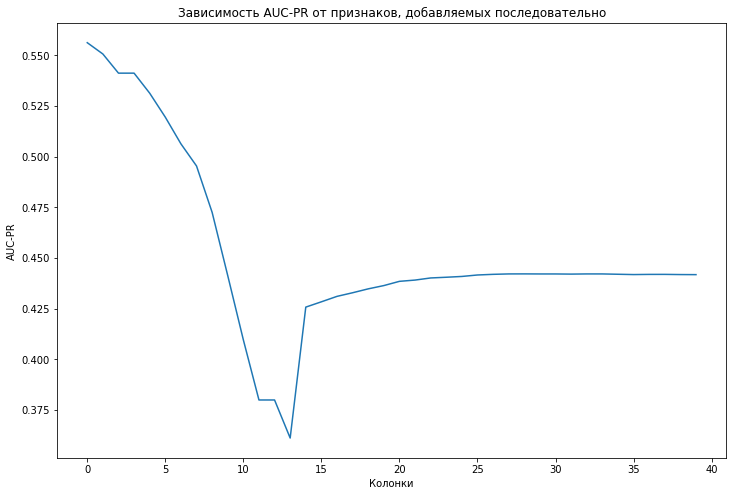

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(gain)
plt.xlabel('Колонки')
plt.ylabel('AUC-PR')
plt.title('Зависимость AUC-PR от признаков, добавляемых последовательно')
plt.show()

Качество модели (по AUC-PR) постепенно ухудшается при добавлении первых 14 лучших признаков, затем идет на плато. 20 признаков будет достаточно.

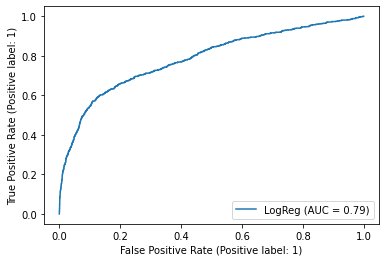

In [ ]:
RocCurveDisplay.from_predictions(
    y_test, y_pred, name="LogReg"
)
plt.show()

Только первый сильный признак

In [ ]:
X_train_ohe = pd.DataFrame(column_transformer.fit_transform(X_train), 
                           columns=column_transformer.get_feature_names_out())

X_test_ohe = pd.DataFrame(column_transformer.transform(X_test), 
                          columns=column_transformer.get_feature_names_out())

X_train_ohe.set_index(y_train.index, inplace=True)
X_test_ohe.set_index(y_test.index, inplace=True)

X_train_ohe = X_train_ohe[['ohe__default_yes']]
X_test_ohe = X_test_ohe[['ohe__default_yes']]

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print(f'AUC-PR: {round(auc(recall, precision), 5)}')

AUC-PR: 0.55632


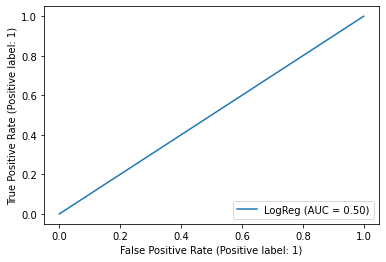

In [ ]:
RocCurveDisplay.from_predictions(
    y_test, y_pred, name="LogReg"
)
plt.show()

Насмотря на более высокий AUC-PR, AUC-ROC минимален при использовании только одного лучшего признака.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Перед отбором признаков, необходимо проводить масштабирование признаков и кодирование категорий. Встроенный метод показал неплохие результаты при хорошей скорости работы. Метод-обертка в данном случае не показал выдающихся результатов, к тому же скорость его работы очень низкая. К лучшему результату привел фильтрующий метод с использованием t-статистики за приемлемое время.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 12 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num)
])

pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

auc_pr = []
profit = []
clean_profit = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr.append(round(auc(recall, precision), 5))

    prec_score = precision_score(y_test, model.predict(X_test))
    preds_sum = sum(model.predict(X_test))
    profit.append(prec_score * 10 * preds_sum)
    clean_profit.append(prec_score * 10 * preds_sum - preds_sum)

In [ ]:
print(f'Значения AUC-PR на 5 фолдах: {auc_pr}\n')

print(f'Среднее значение выручки: {np.mean(profit)}')
print(f'std выручки: {round(np.std(profit), 1)}\n')

print(f'Среднее значение прибыли: {np.mean(clean_profit)}')
print(f'std прибыли: {round(np.std(clean_profit), 1)}\n')

print(f'Отдадим работникам (в среднем): {round(np.mean(profit) - np.mean(clean_profit), 1)}')

Значения AUC-PR на 5 фолдах: [0.45579, 0.45139, 0.41614, 0.46924, 0.4637]

Среднее значение выручки: 2138.0
std выручки: 183.8

Среднее значение прибыли: 1813.6
std прибыли: 164.4

Отдадим работникам (в среднем): 324.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat),
    ('scaler', StandardScaler(), num)
])

pipeline = Pipeline([
    ('transform', column_transformer),
    ('model', LogisticRegression(max_iter=10000))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

auc_pr = []
profit = []
clean_profit = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr.append(round(auc(recall, precision), 5))

    prec_score = precision_score(y_test, model.predict(X_test))
    preds_sum = sum(model.predict(X_test))
    prices = np.random.uniform(0, 20, len(y_pred)) * model.predict(X_test)
    profit.append(prec_score * prices.sum())
    clean_profit.append(prec_score * prices.sum() - preds_sum)

In [ ]:
print(f'Значения AUC-PR на 5 фолдах: {auc_pr}\n')

print(f'Среднее значение выручки: {round(np.mean(profit), 1)}')
print(f'std выручки: {round(np.std(profit), 1)}\n')

print(f'Среднее значение прибыли: {round(np.mean(clean_profit), 1)}')
print(f'std прибыли: {round(np.std(clean_profit), 1)}\n')

print(f'Отдадим работникам (в среднем): {round(np.mean(profit) - np.mean(clean_profit), 1)}')

Значения AUC-PR на 5 фолдах: [0.45579, 0.45139, 0.41614, 0.46924, 0.4637]

Среднее значение выручки: 2149.4
std выручки: 142.7

Среднее значение прибыли: 1825.0
std прибыли: 125.2

Отдадим работникам (в среднем): 324.4
